In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from core.signature_verification import compare_boundary_signatures

/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
import os
import random
import itertools
import pandas as pd

def random_images(dataset_folder):
    random_images = []
    
    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        if not os.path.isdir(person_folder_path) or person_folder.startswith('.'):
            continue

        filenames = [f for f in os.listdir(person_folder_path)
                     if os.path.isfile(os.path.join(person_folder_path, f))]
        
        if len(filenames) > 7:
            filenames = random.sample(filenames, 7)
        
        for filename in filenames:
            full_path = os.path.join(person_folder_path, filename)
            random_images.append(full_path)
    
    return random_images


def duplet_dataset_preparation(dataset_folder):
    image_paths = random_images(dataset_folder)
    all_data = []

    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        
        # Skip if not a directory or hidden
        if not os.path.isdir(person_folder_path) or person_folder.startswith('.'):
            continue

        genuine_images = []
        forged_images = []

        for filename in os.listdir(person_folder_path):
            filepath = os.path.join(person_folder_path, filename)
            if 'original' in filename or '-G-' in filename or 'genuine' in filename:
                genuine_images.append(filepath)
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(filepath)

        # Add some random forged images from other persons to increase variability
        additional_images = random.sample(image_paths, min(10, len(image_paths)))
        forged_images.extend(additional_images)

        # Calculate possible pairs
        num_genuine_combinations = len(genuine_images) * (len(genuine_images) - 1) // 2
        num_forged_combinations = len(genuine_images) * len(forged_images)
        num_combinations = min(num_genuine_combinations, num_forged_combinations)

        if num_combinations == 0:
            continue

        genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
        forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

        for (img1, img2), (g_img, f_img) in zip(genuine_combinations, forged_combinations):
            all_data.append([img1, img2, 1])  # label 1 for genuine pair
            all_data.append([g_img, f_img, 0])  # label 0 for forgery pair

    df = pd.DataFrame(all_data, columns=['image1', 'image2', 'label'])
    return df


In [3]:
datasets = '/Users/saurabshrestha/Downloads/cheques/signature/cheques_images'
data_df = duplet_dataset_preparation(datasets)


In [4]:
data_df = data_df.sample(100)

🔄 Extracting boundary-based signatures...
📊 Signature 1: 4394 boundary points
📊 Signature 2: 7169 boundary points
1_Signature_1_genuine.png---2_Signature_2_genuine.png--0.41746106019648566
🔄 Extracting boundary-based signatures...
📊 Signature 1: 7190 boundary points
📊 Signature 2: 7190 boundary points
2_Signature_2_genuine.png---4_Signature_2_genuine.png--0.9999999986866461
🔄 Extracting boundary-based signatures...
📊 Signature 1: 8868 boundary points
📊 Signature 2: 6683 boundary points
5_Signature_2_genuine.png---10_Signature_1_genuine.png--0.7429502768475889
🔄 Extracting boundary-based signatures...
📊 Signature 1: 1043 boundary points
📊 Signature 2: 1043 boundary points
2_Signature_1_genuine.png---5_Signature_1_genuine.png--0.9999999991237385
🔄 Extracting boundary-based signatures...
📊 Signature 1: 4465 boundary points
📊 Signature 2: 4853 boundary points
1_Signature_2_genuine.png---3_Signature_1_genuine.png--0.8092801306976036
🔄 Extracting boundary-based signatures...
📊 Signature 1: 3

/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/saurabshrestha/Downloads/cheques/signature_verification/src/core/signature_verification.py:359: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  h_corr, _ = pearsonr(h_proj1_resized, h_proj2_resized)
/Users/saurabshrestha/Downloads/cheques/signature_verification/src/core/signature_verification.py:367: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  v_corr, _ = pearsonr(v_proj1_resized, v_proj2_resized)


📊 Signature 1: 2954 boundary points
📊 Signature 2: 3991 boundary points
2_Signature_2_genuine.png---3_Signature_1_genuine.png--0.7278335022540942
🔄 Extracting boundary-based signatures...
📊 Signature 1: 4875 boundary points
📊 Signature 2: 3854 boundary points
2_Signature_1_genuine.png---1_Signature_2_genuine.png--0.5648618120646776
🔄 Extracting boundary-based signatures...
📊 Signature 1: 5345 boundary points
📊 Signature 2: 3945 boundary points
4_Signature_1_genuine.png---1_Signature_1_genuine.png--0.584022302718414
🔄 Extracting boundary-based signatures...
📊 Signature 1: 4169 boundary points
📊 Signature 2: 7151 boundary points
5_Signature_2_genuine.png---4_Signature_1_genuine.png--0.4821717708061628
🔄 Extracting boundary-based signatures...
📊 Signature 1: 7602 boundary points
📊 Signature 2: 5580 boundary points
11_Signature_2_genuine.png---4_Signature_2_genuine.png--0.5873145938804514
🔄 Extracting boundary-based signatures...
📊 Signature 1: 3358 boundary points
📊 Signature 2: 3358 boun

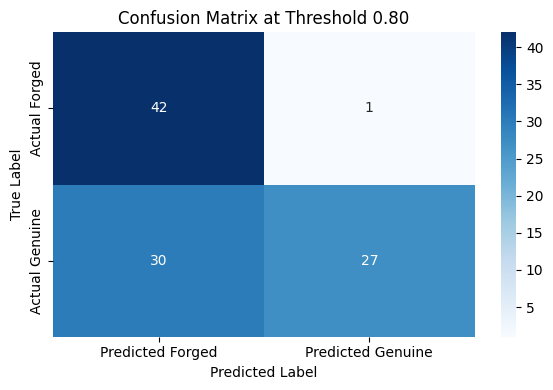

In [5]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded with columns: image1, image2, label
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the signature comparison function
def get_basename(file_path):
    return os.path.basename(file_path)
    
def get_score(row):
    try:
        result = compare_boundary_signatures(row['image1'], row['image2'])  # returns dict
        print(f"{get_basename(row['image1'])}---{get_basename(row['image2'])}--{result['label']}---{result['final_score']}")
        return result['final_score']  # extract final_score directly
    except Exception as e:
        return 1

data_df['score'] = data_df.apply(get_score, axis=1)

# Apply threshold to determine predicted label
threshold = 0.80
data_df['predicted'] = data_df['score'].apply(lambda x: 1 if x >= threshold else 0)

cm = confusion_matrix(data_df['label'], data_df['predicted'], labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Actual Forged', 'Actual Genuine'],
                        columns=['Predicted Forged', 'Predicted Genuine'])
# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Threshold 0.80')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



In [10]:
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)

FAR = fp / (fp + tn)  # False Acceptance Rate: Forged accepted as Genuine
FRR = fn / (fn + tp)  # False Rejection Rate: Genuine rejected as Forged

print(f"Accuracy: {accuracy:.4f}")
print(f"False Acceptance Rate (FAR): {FAR:.4f}")
print(f"False Rejection Rate (FRR): {FRR:.4f}")


Accuracy: 0.6900
False Acceptance Rate (FAR): 0.0233
False Rejection Rate (FRR): 0.5263


In [11]:
import pandas as pd

# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Don't truncate column contents
pd.set_option('display.max_colwidth', None)

# Expand output display width
pd.set_option('display.width', None)


In [8]:
# data_df

In [12]:
import matplotlib.image as mpimg

# Filter for forged images predicted as genuine (False Negative)
# Assuming label=0 is Forged, predicted=1 is Genuine => FN is forged predicted as genuine
fn_df = data_df[(data_df['label'] == 0) & (data_df['predicted'] == 1)]

# Plot a few examples (max 5 to keep it manageable)
num_to_show = min(5, len(fn_df))
plt.figure(figsize=(8, num_to_show * 4))
for i, (_, row) in enumerate(fn_df.head(num_to_show).iterrows()):
    # Load images
    try:
        img1 = mpimg.imread(row['image1'])
        img2 = mpimg.imread(row['image2'])
        
        # Plot side by side
        plt.subplot(num_to_show, 2, 2*i + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Image1\n{os.path.basename(row['image1'])}")

        plt.subplot(num_to_show, 2, 2*i + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Image2\n{os.path.basename(row['image2'])}\nScore: {row['score']:.3f}")
    except Exception as e:
        print(e)
plt.suptitle("Forged images predicted as Genuine (False Positives)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



cannot identify image file '/Users/saurabshrestha/Downloads/cheques/signature/cheques_images/00000032601010000590/.DS_Store'


<Figure size 800x400 with 0 Axes>

In [ ]:
def plot_images_before_after(original_img, normalized_img, title="Image"):
    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray') 
    plt.title(f'Original: {title}')
    plt.axis('off') 

    plt.subplot(1, 2, 2)
    plt.imshow(normalized_img, cmap='gray')
    plt.title(f'Normalized: {title}')
    plt.axis('off') 

    plt.tight_layout()
    plt.show()

In [ ]:
from preprocess.normalize import normalize_image
import cv2

input_directory = '/kaggle/working/outputs_new'
output_directory = '/kaggle/working/outputs_center/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')

print(f"Processing images from: {input_directory}")
processed_count = 0
for filename in os.listdir(input_directory):
    if filename.lower().endswith(image_extensions):
        image_path = os.path.join(input_directory, filename)
        
        try:
            real_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if real_image is None:
                print(f"Error: Could not load image from {image_path}. Skipping.")
                continue

            print(f"Loaded '{filename}' with shape: {real_image.shape}")
            
            desired_canvas_size = (840, 1360) #
            
            # Normalize the image
            normalized_real_image = normalize_image(real_image, size=desired_canvas_size)
            
            print(f"Normalized '{filename}' shape: {normalized_real_image.shape}")

            # # Save the normalized image to the output directory
            # output_filepath = os.path.join(output_directory, f"normalized_{filename}")
            # cv2.imwrite(output_filepath, normalized_real_image)
            processed_count += 1
            plot_images_before_after(real_image, normalized_real_image, title=filename)
        except Exception as e:
            print(f"An error occurred while processing '{filename}': {e}")
if processed_count == 0:
    print("No image files found or processed in the specified directory.")
else:
    print(f"\nFinished processing. Total images normalized: {processed_count}")